## Waste Waste, Don't Tell Me!

In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import json
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Try to lock down determinism as much as possible
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)  # Consistent hash operations
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2025-05-31 20:35:28.272748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### EDA

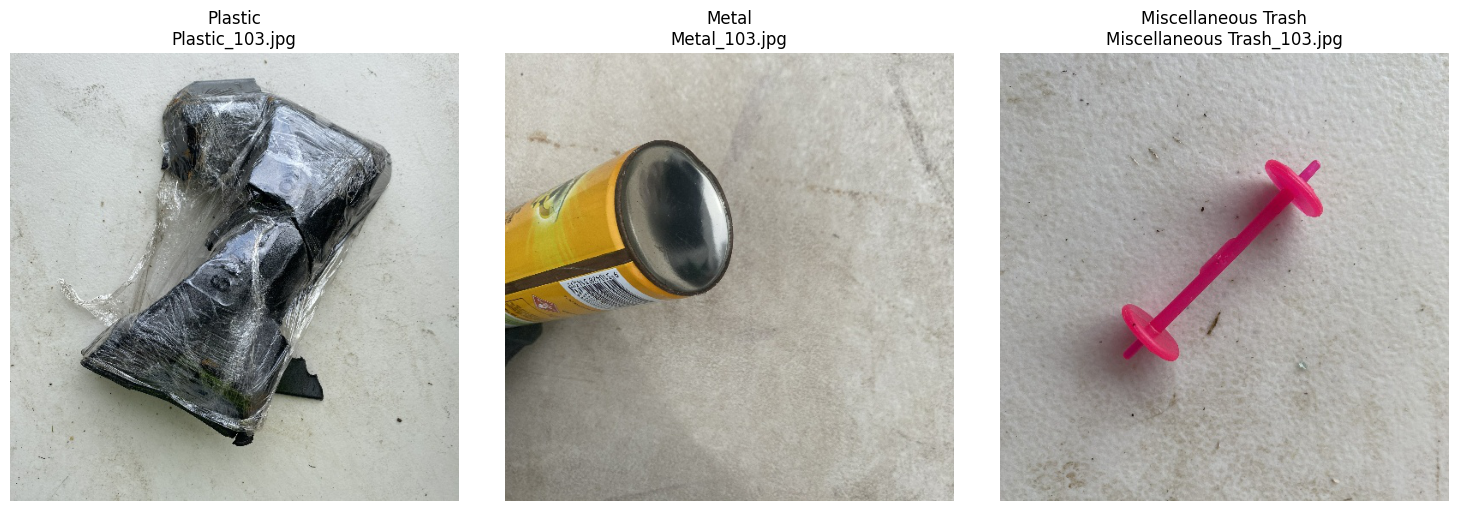

In [2]:
# load 3 images

categories = ["Plastic", "Metal", "Miscellaneous Trash"]
base_path = "data/RealWaste"
index = 5

def load_image_by_index(category, idx):
    folder_path = os.path.join(base_path, category)
    image_files = sorted(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_files[idx])
    return cv2.imread(image_path), category, image_path

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, category in enumerate(categories):
    img, label, path = load_image_by_index(category, index)
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"{label}\n{os.path.basename(path)}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Preprocess Images/Prepare Text Data

In [3]:
# code

### CNN Model for Visual Classification of Waste

In [4]:
input_shape = (128, 128, 3)  # Resize images to 128x128
num_classes = 9  # Number of waste categories

def build_cnn_model(num_classes=9):
    model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), activation="relu", 
                    kernel_regularizer=l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),  # Increased dropout to prevent memorization
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
    return model

model = build_cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,801 (12.61 MB)

 Trainable params: 3,305,801 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
image_size = (128, 128)
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

train_generator = datagen.flow_from_directory(
    "data/train/RealWaste",  
    target_size=image_size,
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    "data/val/RealWaste",  
    target_size=image_size,
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True
)


Found 3798 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [3]:
print(val_generator.classes[:10])

[0 0 0 0 0 0 0 0 0 0]


In [6]:
model_path = "trained_cnn_model.keras"

# Check if the trained model exists
if os.path.exists(model_path):
    print("Loading pre-trained model...")
    model = tf.keras.models.load_model(model_path)
else:
    print("Training new model...")
    
    model = build_cnn_model()

    # Train the model
    epochs = 20
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )

    # Save the trained model
    model.save(model_path)
    print("Model training complete. Saved as trained_cnn_model.keras")

Loading pre-trained model...


In [7]:
model.save("trained_cnn_model.keras")

results = model.evaluate(val_generator)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")


/home/paul/miniconda3/envs/basic_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5353 - loss: 2.1894
Validation Loss: 2.2311
Validation Accuracy: 0.5258


In [28]:
print("Predicted labels:", y_pred[:10])  # Compare first 10
print("Actual labels:", val_generator.classes[:10])

Predicted labels: [4 5 3 1 6 7 4 1 6 0]
Actual labels: [0 0 0 0 0 0 0 0 0 0]


In [27]:
y_pred = np.argmax(model.predict(val_generator), axis=1)
print(np.unique(y_pred, return_counts=True))

print("==========")
print(val_generator.classes[:10])  # Check actual labels
y_pred = np.argmax(model.predict(val_generator), axis=1)
print(y_pred[:10])  # Check predicted labels

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([103,  82,  78, 153,  92, 106, 175,  59, 101]))
[0 0 0 0 0 0 0 0 0 0]
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step
[4 5 3 1 6 7 4 1 6 0]


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step


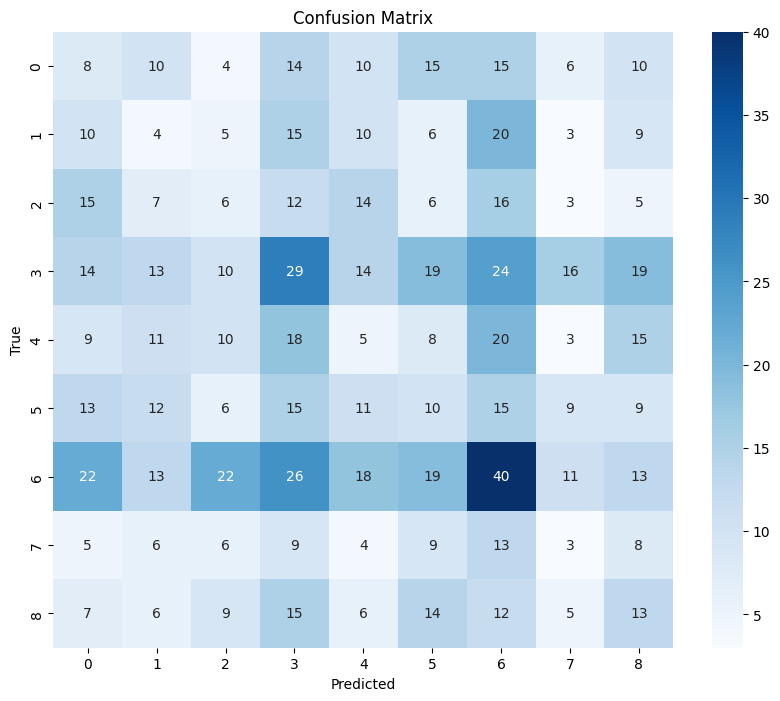

In [8]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = val_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [9]:
if "history" in locals():
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()
else:
    print("no history available, skipping plot")

no history available, skipping plot


### Overfitting Analysis

The model has a serious case of the overfits. There also appears to be some discrepancy between the resulst from `results = model.evaluate(val_generator)` which suggest 52% accuracy, and the confusion matrix above, which suggests an accuracy more like 15% and seems no better than random guessing (no notable representation on the "correct" diagonal of prediction = true). 

In [10]:
# this didn't get us anywhere

# model.load_weights("trained_cnn_model.keras")

# new_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Reduced learning rate
# model.compile(optimizer=new_optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath="cnn_checkpoint.keras",
#     save_best_only=True,
#     monitor="val_loss",
#     mode="min",  # Saves when val_loss decreases
#     verbose=1
# )

# history_finetune = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=5,  # Short fine-tuning phase
#     callbacks=[checkpoint_callback]
# )

### CSV/json

In [11]:
csv_path = "data/waste_descriptions.csv"
df_waste = pd.read_csv(csv_path)

print(df_waste.head(1))

json_path = "data/waste_policy_documents.json"
with open(json_path, "r") as f:
    waste_policy = json.load(f)

print(json.dumps(waste_policy, indent=4))

                description       category  \
0  soiled silver tablecloth  Textile Trash   

                                disposal_instruction common_confusion  \
0  Look for textile recycling programs in your area.              NaN   

                                material_composition  
0  Fabric made from natural or synthetic fibers, ...  
[
    {
        "policy_id": 1,
        "policy_type": "Textile Trash Recycling Guidelines",
        "categories_covered": [
            "Textile Trash"
        ],
        "effective_date": "2023-11-04",
        "document_text": "TEXTILE RECYCLING GUIDELINES\n\nAcceptable Items:\n- Clean clothing (all conditions)\n- Towels, sheets, and linens\n- Fabric scraps\n- Curtains and cloth napkins\n- Handbags and backpacks made of fabric\n- Soft toys and stuffed animals\n\nNon-Acceptable Items:\n- Wet or moldy textiles\n- Heavily soiled items\n- Carpets and rugs\n- Footwear\n- Items with significant non-textile parts\n\nCollection Method:\nPlace items

soiled silver tablecloth,Textile Trash
folded glass bottle leaking,Glass,
large Supermarket vegetable waste with food residue,Food Organics


In [12]:
# Preprocess text (basic)
df_waste["cleaned_text"] = df_waste["description"].str.lower()

# TF-IDF + Logistic Regression Pipeline
model_pipeline = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000)
)

# Train
X_train, X_test, y_train, y_test = train_test_split(
    df_waste["cleaned_text"],  # Use actual descriptions, NOT labels
    df_waste["category"],      # Keep correct target variable
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df_waste["category"]  # Ensure balanced splits
)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [13]:
print(df_waste.isnull().sum())
print(len(df_waste))
print(df_waste[df_waste["common_confusion"].notnull()].sample(5)[["description", "common_confusion"]])


description                0
category                   0
disposal_instruction       0
common_confusion        2504
material_composition       0
cleaned_text               0
dtype: int64
5000
                                            description  \
2889                      clean mini yellow meat scraps   
1156  wrinkled transparent paper Artisanal wool sweater   
1157               partial oversized Organic light bulb   
2153                patterned Commercial cardboard tube   
3077    clean standard gold Designer vacuum cleaner bag   

                                       common_confusion  
2889  Meat and dairy products may be restricted in s...  
1156  Some textiles can be recycled or donated, even...  
1157  Window glass, drinking glasses, and ceramics s...  
2153  Pizza boxes with food stains should go in orga...  
3077  Check for hidden recyclable components before ...  


In [14]:
y_pred = model_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

          Cardboard       1.00      1.00      1.00       117
      Food Organics       1.00      1.00      1.00       104
              Glass       1.00      1.00      1.00       110
              Metal       0.98      1.00      0.99       101
Miscellaneous Trash       1.00      0.99      1.00       116
              Paper       0.99      1.00      1.00       101
            Plastic       1.00      1.00      1.00       114
      Textile Trash       1.00      0.98      0.99       117
         Vegetation       1.00      1.00      1.00       120

           accuracy                           1.00      1000
          macro avg       1.00      1.00      1.00      1000
       weighted avg       1.00      1.00      1.00      1000



In [15]:
removed_desc = ['soiled silver tablecloth', # Textile Trash
                'folded glass bottle leaking', #Glass
                'large Supermarket vegetable waste with food residue' #Food Organics
]
cat_preds = model_pipeline.predict(removed_desc)
cat_preds

array(['Textile Trash', 'Glass', 'Food Organics'], dtype=object)

The accuracy is suspiciously low. I tested this by creating a copy of the data and manually removing those first three rows. Relatively small sample, but it was able to. It seems like many descriptions contain a very obvious word. There are also duplicates in the set, so there may be some information leakage because of that.

Testing some examples I created below. Follow-up step would be deduping the list before training.

In [24]:
pizza_pred = model_pipeline.predict(['large Supermarket vegetable waste with pizza grease'])
# Pred = food organics, probably good
print(f"Predicted: {pizza_pred}, Expected/Desired: Food Organics? Misc Trash?")

pizza_pred2 = model_pipeline.predict(['box with pizza grease'])
# pred = cardboard, probably bad - they don't want greasy boxes
print(f"Predicted: {pizza_pred2}, Expected/Desired: Food Organics? Misc Trash?")

ambi_pred = model_pipeline.predict(['clothing hanger (metal) for clothing wrapped in cloth'])
print(f"Predicted: {ambi_pred}, Expected/Desired: Metal")

# Model has no category for dangerous/hazardous materials
#TODO consider scanning for words like "batteries", "radioactive" at some stage

danger_pred = model_pipeline.predict(['plastic batteries'])
danger_pred

Predicted: ['Food Organics'], Expected/Desired: Food Organics? Misc Trash?
Predicted: ['Cardboard'], Expected/Desired: Food Organics? Misc Trash?
Predicted: ['Metal'], Expected/Desired: Metal


array(['Plastic'], dtype=object)

=====================================================
=====================================================
=====================================================
=====================================================
## TF/IDF for Fake RAG

In [17]:

with open("data/waste_policy_documents.json", "r") as f:
    waste_policies = json.load(f)

document_texts = [doc["document_text"] for doc in waste_policies]

print(f"Loaded {len(document_texts)} policy documents.")
print(document_texts[0][:100])


Loaded 14 policy documents.
TEXTILE RECYCLING GUIDELINES

Acceptable Items:
- Clean clothing (all conditions)
- Towels, sheets, 


In [18]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()
document_vectors = vectorizer.fit_transform(document_texts)

print(f"TF-IDF matrix shape: {document_vectors.shape}")  # Verify dimensions


TF-IDF matrix shape: (14, 325)


In [19]:
# Function to retrieve the most relevant policy
def query_policy(query):
    query_vector = vectorizer.transform([query])
    scores = cosine_similarity(query_vector, document_vectors)
    best_match_idx = scores.argmax()
    return document_texts[best_match_idx]

# Test query
query = "How should I recycle glass?"
print(f"Best policy match: {query_policy(query)}")


Best policy match: GLASS RECYCLING GUIDELINES

Acceptable Items:
- Glass bottles (all colors)
- Glass jars
- Glass food containers
- Glass beverage containers

Non-Acceptable Items:
- Window glass or mirrors
- Drinking glasses
- Ceramics or pottery
- Light bulbs
- Pyrex or heat-resistant glass

Collection Method:
Place in dedicated glass recycling bins. Some areas require color sorting.

Preparation Instructions:
- Rinse containers
- Remove caps and lids (recycle separately)
- Labels can remain

Benefits:
Glass is 100% recyclable and can be recycled endlessly without loss of quality.


### Fake/Mocked RAG

I set up TF/IDF as an alternative to RAG, which I was unable to get into a workable state due to dependency issues. This solution is obviously inferior to a good RAG model and not what the assignment intended, but it allows me to move forward with **something**.


================

### Integration

In [ ]:
# def preprocess_image(image_path):
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (128, 128))
#     img = img.astype("float32") / 255.0
#     img = np.expand_dims(img, axis=0)
#     return img
def preprocess_image(cv2_image):
    """ Resizes, normalizes, and formats an OpenCV image for model input. """
    img = cv2.resize(cv2_image, (128, 128))  # Resize to target dimensions
    img = img.astype("float32") / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension for CNN input
    return img

def generate_from_image(image):
    # Expects image to be preprocessed
    # Step 1: Preprocess Image
    #processed_image = preprocess_image(image)  

    # Step 2: Get Waste Classification
    waste_category = model.predict(processed_image)
    waste_category = str(np.argmax(waste_category))
    print(f"Predicted category = {waste_category}")
    
    # Step 3: Retrieve Recycling Policy
    policy_info = query_policy(waste_category)  

    # Step 4: Format Response
    return f"Classified as: {waste_category}\nRecycling Policy:\n{policy_info}"

def generate_from_text(text):
    # call model_pipeline, our text classifier
    None
    asd

def generate_response(input):
    if input is image:
        return generate_from_image(input)
    if input is text:
        return generate_from_text(input)
    else:
        return "Cannot parse input - must be text or image"

In [21]:
test_image, _, _ = load_image_by_index("Metal", 5)
processed_image = preprocess_image(test_image) #type numpy.ndarray
document = generate_from_image(processed_image)

document

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted category = 0


'Classified as: 0\nRecycling Policy:\nTEXTILE RECYCLING GUIDELINES\n\nAcceptable Items:\n- Clean clothing (all conditions)\n- Towels, sheets, and linens\n- Fabric scraps\n- Curtains and cloth napkins\n- Handbags and backpacks made of fabric\n- Soft toys and stuffed animals\n\nNon-Acceptable Items:\n- Wet or moldy textiles\n- Heavily soiled items\n- Carpets and rugs\n- Footwear\n- Items with significant non-textile parts\n\nCollection Method:\nPlace items in dedicated textile recycling bins or donate to local thrift stores.\n\nPreparation Instructions:\n- Ensure all items are clean and dry\n- Remove non-textile components when possible\n- Bag similar items together\n\nBenefits:\nTextile recycling conserves resources and reduces landfill waste.'